In [5]:
import pygplates
import numpy as np
import pandas as pd
import healpy
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def create_gpml_velocity_feature(longitude_array,latitude_array,filename=None,feature_type=None):
# function to make a velocity mesh nodes at an arbitrary set of points
# Long and Lat are assumed to be 1d arrays. 

    multi_point = pygplates.MultiPointOnSphere(zip(latitude_array,longitude_array))

    # Create a feature containing the multipoint feature. 
    # optionally, define as 'MeshNode' type, so that GPlates will recognise it as a velocity layer
    if feature_type=='MeshNode':
        meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
        meshnode_feature.set_name('Velocity Mesh Nodes')
    else:
        meshnode_feature = pygplates.Feature()
        meshnode_feature.set_name('Multipoint Feature')
    
    meshnode_feature.set_geometry(multi_point)
    
    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    if filename is not None:
        output_feature_collection.write(filename)
    else:
        return output_feature_collection

def create_gpml_healpix_mesh(nSide,filename=None,feature_type=None):

    # call the function to create a healpix array
    #nSide = 32
    othetas,ophis = healpy.pix2ang(nSide,np.arange(12*nSide**2))
    othetas = np.pi/2-othetas
    ophis[ophis>np.pi] -= np.pi*2

    lats = np.degrees(othetas) 
    lons = np.degrees(ophis)

    # call the function to create a multipoint feature, with user-defined type
    output_feature_collection = create_gpml_velocity_feature(lons,lats,filename,feature_type)

    if filename is not None:  # This is superfluous, since file has already been written in previous line???
        output_feature_collection.write(filename)
    else:
        return output_feature_collection

In [8]:
#setbasedir for loading reconstruction files
basedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2017_GR/Sample_data/'
rotation_model = pygplates.RotationModel('%sMer17_Neoproterozoic_rotations.rot' % basedir)
polygons = pygplates.FeatureCollection('%sMer17_Neoproterozoic_shapes.gpml' % basedir)

In [9]:
#create equal area mesh
latlon_mesh = create_gpml_healpix_mesh(32)

In [13]:
#we want to bin data into 5° latitudes
#set up bins and how much area each point covers here

#create bins
bins = np.linspace(-90,90,185/5)

#area covered by each point
number_of_points = len(pt_lat)
print 'number of points', len(pt_lat)

#surface area of the earth
r = 6371
surface_area = 4 * np.pi * r ** 2
print 'surface area of the earth', surface_area

area_per_point = surface_area/number_of_points

print 'area per point', area_per_point


number of points 12288
surface area of the earth 510064471.91
area per point 41509.1529875


In [14]:
# Resolve our topological plate polygons (and deforming networks) to the current 'time'.
start_time = 520
end_time = 1000
time_step = 10

latitude_points = []
latlon_array = []

for i in latlon_mesh:
    for point in i.get_geometry():
        latlon_array.append(point.to_lat_lon())


In [277]:
# Resolve our topological plate polygons (and deforming networks) to the current 'time'.

#set times, 520 to 1000 in 10 Ma steps
times = np.arange(520,1000,10)
latitude_points = []
latlon_array = []

#this creates an array of lat/lons of our mesh which we use to query the amount of continental mass at each point
for i in latlon_mesh:
    for point in i.get_geometry():
        latlon_array.append(point.to_lat_lon())

for time in times:
    #print time
    tmp_lat_points = []
    reconstructed_features = []
    
    pygplates.reconstruct(polygons, 
                          rotation_model, 
                          reconstructed_features, 
                          time)
    
    for poly in reconstructed_features:
        poly_geom = poly.get_reconstructed_geometry()

        for i in latlon_array:
            if poly_geom.is_point_in_polygon(i):
                #print i[0]
                tmp_lat_points.append(i[0])
    tmp_data = np.histogram(tmp_lat_points, bins)
    tmp_area = tmp_data[0] * area_per_point
    latitude_points.append(tmp_area)

In [278]:
#turn into an array so we can plot it as a heatmap
latitude_points_array = np.stack(latitude_points, axis=0 )

#save data as a csv if you want
np.savetxt('cont_area_vs_lat.csv', latitude_points_array, delimiter=',')

/Users/Andrew/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


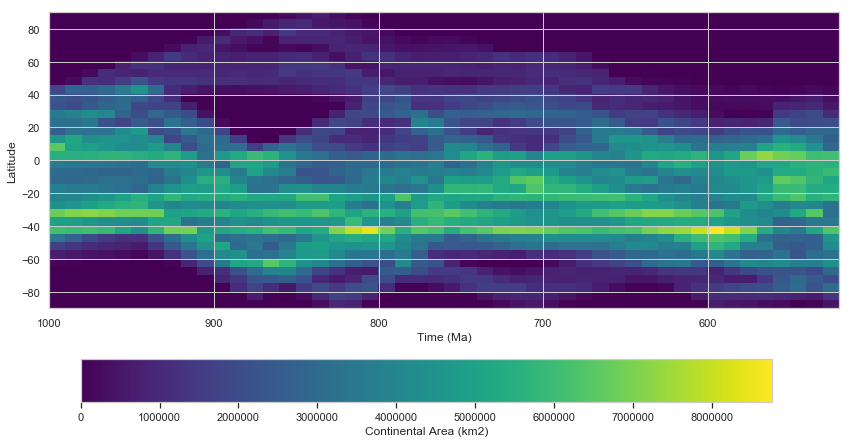

In [286]:
cm = plt.get_cmap('viridis')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12),facecolor='w', edgecolor='k')

#we have to transpose the array because it's around the wrong way
plot = ax.imshow(latitude_points_array.T, origin='lower', extent=[520,1000,-90,90], cmap=cm, interpolation='None')
cax = fig.add_axes([0.1, 0.22, 0.8, 0.05])
cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
cbar.set_label('Continental Area (km2)')
ax.set_xlim(1000,520)
ax.set_xlabel('Time (Ma)')
ax.set_ylabel('Latitude')
plt.tight_layout()